## Use stacked images (3D) and Densenet121 3D model

Acknowledgements:

- https://www.kaggle.com/rluethy/efficientnet3d-with-one-mri-type
- https://www.kaggle.com/davidbroberts/determining-dicom-image-order
- https://www.kaggle.com/ihelon/brain-tumor-eda-with-animations-and-modeling
- https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train
- https://github.com/shijianjian/EfficientNet-PyTorch-3D

This notebook is based on the implementation of Densenet121 3D available here:
https://www.kaggle.com/mikecho/monai-v060-deep-learning-in-healthcare-imaging

It builds 4 models with only one MRI type, then ensembles all of them computing average probabilities


In [1]:
import os
import sys 
import json
import glob
import random
import re
import collections
import time
from pathlib import Path

import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional

import torchio as tio
import nibabel as nib

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import xgboost as xgb

In [2]:
if os.path.exists("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification"):
    data_directory = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification"
    input_monaipath = "/kaggle/input/monai-v060-deep-learning-in-healthcare-imaging/"
    landmarks_directory = "/kaggle/input/rsna-landmarks"
else:
    data_directory = "rsna-miccai-brain-tumor-radiogenomic-classification"
    input_monaipath = "MONAI"
    landmarks_directory = "rsna-landmarks"

processed_data_dir = 'rsna-preprocessed'
experiment_folder = "experiments/seresnext50_stacking"
model_paths = f"{experiment_folder}/models"


In [3]:
os.makedirs(experiment_folder, exist_ok=True)

In [4]:
mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']

SIZE = 256
NUM_IMAGES = 64
BATCH_SIZE = 2
# PATCH_SIZE = (SIZE//2, SIZE//2, 12)

# EPOCHS = 10
# MIN_LR = 1e-6
# LR = 0.001
EPOCHS = 12
LR = 1e-4

NUM_FOLDS = 5
SEED = 42

sys.path.append(input_monaipath)

# worked well ?
# from monai.networks.nets.densenet import DenseNet121
# failed
# from monai.networks.nets.vit import ViT
from monai.networks.nets.senet import SEResNext50


In [5]:
TOTAL_EPOCHS = EPOCHS * len(mri_types) * NUM_FOLDS
TOTAL_EPOCHS

240

## Preprocess Dataset

In [6]:
preprocessing_transforms = (
    tio.ToCanonical(),
    tio.Resample(1, image_interpolation='bspline'),
    tio.Resample('T1w', image_interpolation='nearest'),
)
preprocess = tio.Compose(preprocessing_transforms)

In [7]:
train_set = tio.datasets.RSNAMICCAI(data_directory, train=True, transform=preprocess)
test_set = tio.datasets.RSNAMICCAI(data_directory, train=False, transform=preprocess)

In [8]:
def preprocess_dataset(dataset, out_dir, parallel=True):
    import shutil
    import multiprocessing as mp
    from pathlib import Path
    from tqdm.notebook import tqdm
    out_dir = Path(out_dir)
    labels_name = 'train_labels.csv'
    out_dir.mkdir(exist_ok=True, parents=True)
    shutil.copy(dataset.root_dir / labels_name, out_dir / labels_name)
    subjects_dir = out_dir / ('train' if dataset.train else 'test')
    if parallel:
        loader = torch.utils.data.DataLoader(
            dataset,
            num_workers=mp.cpu_count(),
            collate_fn=lambda x: x[0],
        )
        iterable = loader
    else:
        iterable = dataset
    for subject in tqdm(iterable):
        subject_dir = subjects_dir / subject.BraTS21ID
        for name, image in tqdm(subject.get_images_dict().items(), leave=False):
            image_dir = subject_dir / name
            image_dir.mkdir(exist_ok=True, parents=True)
            image_path = image_dir / f'{name}.nii.gz'
            image.save(image_path)


In [9]:
%%time

if not Path(processed_data_dir).is_dir():
    preprocess_dataset(train_set, processed_data_dir)
    preprocess_dataset(test_set, processed_data_dir)

CPU times: user 29 µs, sys: 15 µs, total: 44 µs
Wall time: 45.8 µs


In [10]:
processed_data_dir = 'rsna-preprocessed'

## Functions to load images

In [11]:
def load_preprocessed_data_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train"):
    path = f"{processed_data_dir}/{split}/{scan_id}/{mri_type}/{mri_type}.nii.gz"
    data = nib.load(path).get_fdata()
    img_count = data.shape[-1]
    every_nth = img_count / num_imgs
    indexes = [min(int(round(i * every_nth)), img_count - 1) for i in range(0, num_imgs)]
    data = data[:, :, indexes]
    data = cv2.resize(data, (SIZE, SIZE))
    data = np.expand_dims(data, axis=0)
    return data

load_preprocessed_data_3d("00000", mri_type=mri_types[0]).shape

(1, 256, 256, 64)

In [12]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(SEED)

## remove samples as described in https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/262046

In [13]:
samples_to_exclude = [109, 123, 709]

df = pd.read_csv(f"{data_directory}/train_labels.csv")
print("original shape", df.shape)
df = df[~df.BraTS21ID.isin(samples_to_exclude)]
print("new shape", df.shape)
display(df)

original shape (585, 2)
new shape (582, 2)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [14]:
# df = df.iloc[:16]

## Model and training classes

In [15]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, landmarks_dict=None, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.landmarks_dict = landmarks_dict
        self.split = split
          
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_preprocessed_data_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
            # augs = [
            #     tio.HistogramStandardization(self.landmarks_dict)
            # ]
            # transforms = tio.Compose(augs)
            # data = transforms(data) 
        else:
            data = load_preprocessed_data_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train")
            #get_foreground = tio.ZNormalization.mean
            augs = [
                # tio.RandomAnisotropy(p=0.25),              # make images look anisotropic 25% of times
                #tio.HistogramStandardization(self.landmarks_dict),
                # TODO: crop only sometimes! this happens all the time which is risky
                # tio.CropOrPad((256, 256, 64)),            # tight crop around brain
                # TODO: calculate landmarks:
                # https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/Data_preprocessing_and_augmentation_using_TorchIO_a_tutorial.ipynb#scrollTo=85COw2H63PfH
                # too strong? (removes part of the scan!)
                # tio.ZNormalization(
                #     masking_method=get_foreground),        # zero mean, unit variance of foreground
                #   works!
                tio.RandomBlur(p=0.15),                    # blur 15% of times
                tio.RandomNoise(p=0.15),                   # noise 15% of times
                tio.RandomAffine(p=0.4),                   # affine transforms applied to 40% of images
                tio.RandomBiasField(p=0.2),                # magnetic field inhomogeneity 20% of times
                tio.OneOf({                                # either
                    tio.RandomMotion(): 1,                 # random motion artifact
                    tio.RandomSpike(): 2,                  # or spikes
                    tio.RandomGhosting(): 2,               # or ghosts
                }, p=0.2),                                 # applied to 20% of images
            ]
            transforms = tio.Compose(augs)
            data = transforms(data)

            # import matplotlib.pyplot as plt
            # fig, axs = plt.subplots(2)
            # axs[0].imshow(data[0, :, :, 32], vmin=0, vmax=1)
            # print(data.shape)
            # data = transforms(data)
            # print(data.shape)
            # axs[1].imshow(data[0, :, :, 32], vmin=0, vmax=1)
            # plt.show()
            # print("============")
            
        if self.targets is None:
            return {"X": data, "id": scan_id}
        else:
            return {"X": data, "y": torch.tensor(self.targets[index], dtype=torch.float)}


In [16]:
def build_model():
    # model = DenseNet121(in_channels=1, out_channels=1, spatial_dims=3)
    # model = ViT(
    #     in_channels=1,
    #     img_size=(SIZE, SIZE, NUM_IMAGES),
    #     patch_size=PATCH_SIZE,
    #     spatial_dims=3,
    #     pos_embed='conv',
    #     classification=True,
    #     num_classes=1
    # )
    model = SEResNext50(in_channels=1, num_classes=1, spatial_dims=3)
    return model    

In [17]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer,
            max_lr=LR,
            epochs=EPOCHS,
            div_factor=25,
            pct_start=0.25,
            steps_per_epoch=1,
            final_div_factor=1e5
        )
        # self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=LR_DECAY)
        self.criterion = criterion

        self.best_valid_score = .0
        self.n_patience = 0
        self.lastmodel = None
        
        self.val_losses = []
        self.train_losses = []
        self.val_auc = []
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):      
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(valid_loss)
            self.val_auc.append(valid_auc)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            if self.best_valid_score < valid_auc: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_auc, self.lastmodel
                )
                self.best_valid_score = valid_auc
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for param_group in self.optimizer.param_groups:
            print(f"Learning Rate: {param_group['lr']}")

        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].clone().detach().float().to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            # outputs = self.model(X)[0].squeeze(1)
            loss = self.criterion(outputs, targets)

            loss.backward()

            sum_loss += loss.detach().item()
            
            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
        self.lr_scheduler.step()
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                targets = batch["y"].to(self.device)

                # outputs = torch.sigmoid(self.model(batch["X"].clone().detach().float().to(self.device)).squeeze(1))
                outputs = self.model(batch["X"].clone().detach().float().to(self.device))
                outputs = outputs.squeeze(1)
                outputs = torch.sigmoid(outputs)
                loss = self.criterion(outputs, targets)
                sum_loss += loss.detach().item()

                y_all.extend(batch["y"].tolist())
                outputs_all.extend(outputs.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
        
    def display_plots(self, mri_type):
        plt.figure(figsize=(10,5))
        plt.title("{}: Training and Validation Loss")
        plt.plot(self.val_losses,label="val")
        plt.plot(self.train_losses,label="train")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.figure(figsize=(10,5))
        plt.title("{}: Validation AUC-ROC")
        plt.plot(self.val_auc,label="val")
        plt.xlabel("iterations")
        plt.ylabel("AUC")
        plt.legend()
        plt.show()
        plt.close()
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

# Prediction

In [18]:
def predict(model, df, mri_type, split):
    print("Predict:", mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    
    landmarks = torch.load(os.path.join(landmarks_directory, (f"{mri_type}_landmarks.npy")))
    landmarks_dict = {
        "default_image_name": landmarks,
    }

    data_retriever = Dataset(
        paths=df["BraTS21ID"].values,
        mri_type=df["MRI_Type"].values,
        split=split,
        landmarks_dict=landmarks_dict
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].clone().detach().float().to(device)).squeeze(1)).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    return y_pred

## train loop

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df, df_test, mri_type, skf):

    oof_train = np.zeros((len(df)))
    oof_test = np.zeros((len(df_test)))
    oof_test_skf = np.empty((5, len(df_test)))

    lastmodels = []
    for i, (train_index, val_index) in enumerate(skf.split(df, df["MGMT_value"], df["MGMT_value"])):
        df_train = df.iloc[train_index]
        df_valid = df.iloc[val_index]
        
        train = df_train.copy()
        valid = df_valid.copy()
        train.loc[:,"MRI_Type"] = mri_type
        valid.loc[:,"MRI_Type"] = mri_type

        print(train.shape, valid.shape)
        display(valid.head())
        print(len(train))
        display(valid.head())
        print(len(valid))

        landmarks = torch.load(os.path.join(landmarks_directory, (f"{mri_type}_landmarks.npy")))
        landmarks_dict = {
            "default_image_name": landmarks,
        }

        train_data_retriever = Dataset(
            train["BraTS21ID"].values, 
            train["MGMT_value"].values, 
            train["MRI_Type"].values,
            landmarks_dict=landmarks_dict
        )

        valid_data_retriever = Dataset(
            valid["BraTS21ID"].values, 
            valid["MGMT_value"].values,
            valid["MRI_Type"].values,
            landmarks_dict=landmarks_dict
        )

        train_loader = torch_data.DataLoader(
            train_data_retriever,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=8,
        )

        valid_loader = torch_data.DataLoader(
            valid_data_retriever, 
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=8,
        )

        model = build_model()
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=LR)

        criterion = torch_functional.binary_cross_entropy_with_logits

        trainer = Trainer(
            model, 
            device, 
            optimizer, 
            criterion
        )

        save_path = f"{experiment_folder}/{model_paths}/fold_{i}/{mri_type}" 
        os.makedirs(save_path, exist_ok=True)
        history = trainer.fit(
            EPOCHS, 
            train_loader, 
            valid_loader, 
            save_path,
            EPOCHS,
        )

        trainer.display_plots(mri_type)

        oof_train[val_index] = predict(model, df_valid, mri_type, "train")
        oof_test_skf[i, :] = predict(model, df_test, mri_type, "test")

        lastmodels.append(trainer.lastmodel)

    oof_test = oof_test_skf.mean(axis=0)

    return oof_train, oof_test, lastmodels

In [20]:
df_test = pd.read_csv(f"{data_directory}/sample_submission.csv")
df_test["MGMT_value"] = 0

In [21]:
rkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,FLAIR
6,9,0,FLAIR
7,11,1,FLAIR
17,25,1,FLAIR
18,26,1,FLAIR


465


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,FLAIR
6,9,0,FLAIR
7,11,1,FLAIR
17,25,1,FLAIR
18,26,1,FLAIR


117
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6989, time: 257.00 s
[Epoch Valid: 1] loss: 0.7117, auc: 0.5331, time: 36.00 s
auc improved from 0.0000 to 0.5331. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_0/FLAIR-e1-loss0.712-auc0.533.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7112, time: 257.00 s
[Epoch Valid: 2] loss: 0.7010, auc: 0.6079, time: 35.00 s
auc improved from 0.5331 to 0.6079. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_0/FLAIR-e2-loss0.701-auc0.608.pth'
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7158, time: 243.00 s
[Epoch Valid: 3] loss: 0.7176, auc: 0.6126, time: 42.00 s
auc improved from 0.6079 to 0.6126. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_0/FLAIR-e3-loss0.718-auc0.613.pth'
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] lo

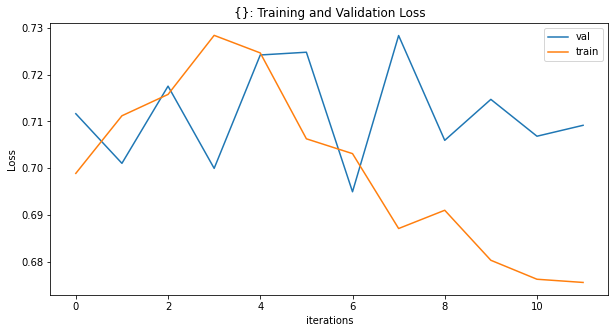

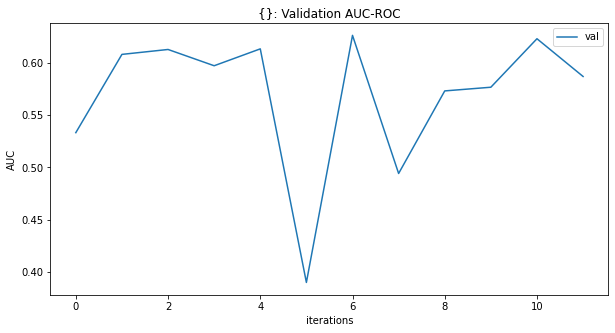

Predict: FLAIR (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 2)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,FLAIR
3,5,1,FLAIR
8,12,1,FLAIR
10,17,0,FLAIR
14,21,0,FLAIR


465


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,FLAIR
3,5,1,FLAIR
8,12,1,FLAIR
10,17,0,FLAIR
14,21,0,FLAIR


117
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6900, time: 242.00 s
[Epoch Valid: 1] loss: 0.7133, auc: 0.5038, time: 40.00 s
auc improved from 0.0000 to 0.5038. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_1/FLAIR-e1-loss0.713-auc0.504.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7100, time: 239.00 s
[Epoch Valid: 2] loss: 0.7107, auc: 0.4804, time: 38.00 s
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7254, time: 241.00 s
[Epoch Valid: 3] loss: 0.7014, auc: 0.5902, time: 37.00 s
auc improved from 0.5038 to 0.5902. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_1/FLAIR-e3-loss0.701-auc0.590.pth'
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7289, time: 242.00 s
[Epoch Valid: 4] loss: 0.7312, auc: 0.5319, time: 34.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7055, tim

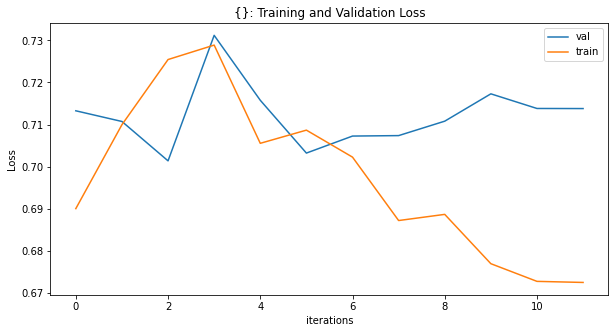

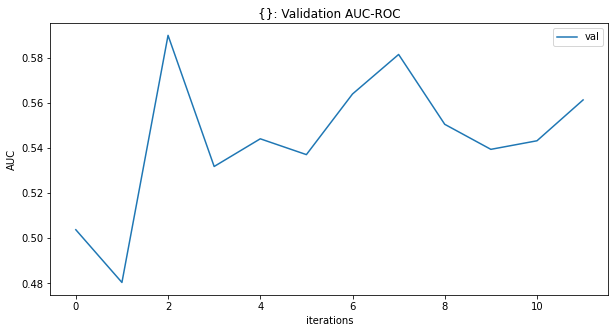

Predict: FLAIR (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,FLAIR
1,2,1,FLAIR
9,14,1,FLAIR
13,20,1,FLAIR
23,33,1,FLAIR


466


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,FLAIR
1,2,1,FLAIR
9,14,1,FLAIR
13,20,1,FLAIR
23,33,1,FLAIR


116
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6945, time: 242.00 s
[Epoch Valid: 1] loss: 0.7176, auc: 0.3928, time: 33.00 s
auc improved from 0.0000 to 0.3928. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_2/FLAIR-e1-loss0.718-auc0.393.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7067, time: 243.00 s
[Epoch Valid: 2] loss: 0.7069, auc: 0.5878, time: 33.00 s
auc improved from 0.3928 to 0.5878. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_2/FLAIR-e2-loss0.707-auc0.588.pth'
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7191, time: 242.00 s
[Epoch Valid: 3] loss: 0.7226, auc: 0.6146, time: 31.00 s
auc improved from 0.5878 to 0.6146. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_2/FLAIR-e3-loss0.723-auc0.615.pth'
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] lo

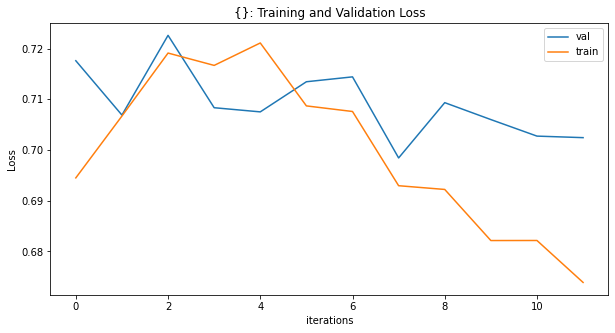

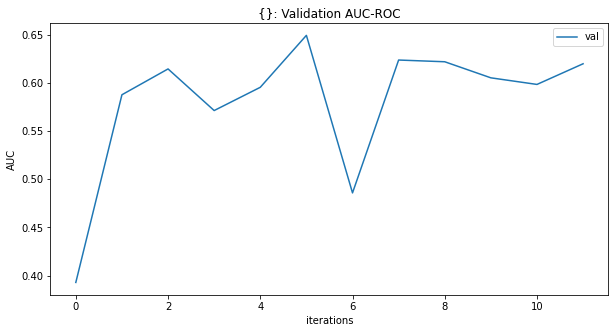

Predict: FLAIR (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,FLAIR
11,18,0,FLAIR
12,19,0,FLAIR
16,24,0,FLAIR
20,30,0,FLAIR


466


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,FLAIR
11,18,0,FLAIR
12,19,0,FLAIR
16,24,0,FLAIR
20,30,0,FLAIR


116
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6825, time: 245.00 s
[Epoch Valid: 1] loss: 0.7050, auc: 0.5708, time: 33.00 s
auc improved from 0.0000 to 0.5708. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_3/FLAIR-e1-loss0.705-auc0.571.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7156, time: 244.00 s
[Epoch Valid: 2] loss: 0.7202, auc: 0.4113, time: 34.00 s
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7126, time: 243.00 s
[Epoch Valid: 3] loss: 0.7126, auc: 0.4036, time: 34.00 s
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7367, time: 242.00 s
[Epoch Valid: 4] loss: 0.7383, auc: 0.5770, time: 33.00 s
auc improved from 0.5708 to 0.5770. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_3/FLAIR-e4-loss0.738-auc0.577.pth'
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7226, tim

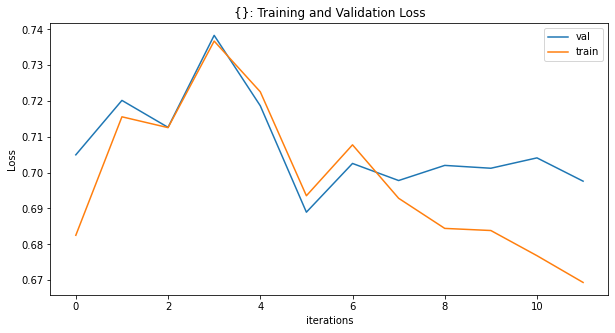

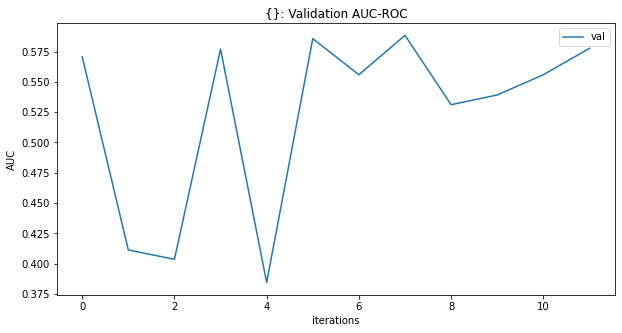

Predict: FLAIR (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,FLAIR
22,32,0,FLAIR
27,44,0,FLAIR
32,52,1,FLAIR
36,58,1,FLAIR


466


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,FLAIR
22,32,0,FLAIR
27,44,0,FLAIR
32,52,1,FLAIR
36,58,1,FLAIR


116
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6916, time: 241.00 s
[Epoch Valid: 1] loss: 0.7099, auc: 0.5779, time: 34.00 s
auc improved from 0.0000 to 0.5779. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_4/FLAIR-e1-loss0.710-auc0.578.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7129, time: 244.00 s
[Epoch Valid: 2] loss: 0.6979, auc: 0.5452, time: 40.00 s
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7231, time: 242.00 s
[Epoch Valid: 3] loss: 0.7049, auc: 0.4480, time: 36.00 s
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7189, time: 244.00 s
[Epoch Valid: 4] loss: 0.7182, auc: 0.5797, time: 36.00 s
auc improved from 0.5779 to 0.5797. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_4/FLAIR-e4-loss0.718-auc0.580.pth'
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7099, tim

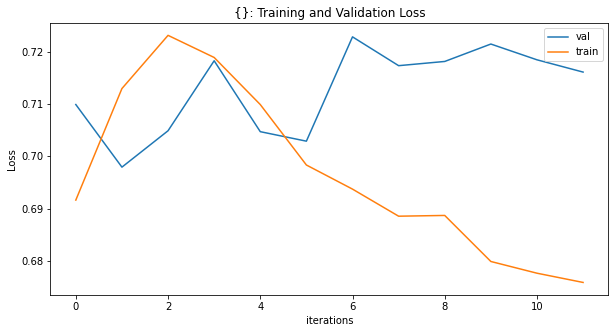

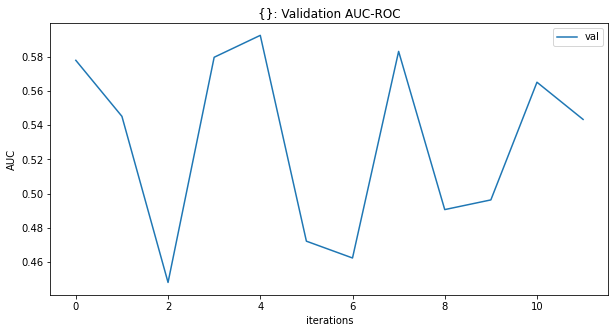

Predict: FLAIR (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,T1w
6,9,0,T1w
7,11,1,T1w
17,25,1,T1w
18,26,1,T1w


465


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,T1w
6,9,0,T1w
7,11,1,T1w
17,25,1,T1w
18,26,1,T1w


117
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6955, time: 242.00 s
[Epoch Valid: 1] loss: 0.7115, auc: 0.5927, time: 35.00 s
auc improved from 0.0000 to 0.5927. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_0/T1w-e1-loss0.712-auc0.593.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7211, time: 244.00 s
[Epoch Valid: 2] loss: 0.7053, auc: 0.6287, time: 34.00 s
auc improved from 0.5927 to 0.6287. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_0/T1w-e2-loss0.705-auc0.629.pth'
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7355, time: 244.00 s
[Epoch Valid: 3] loss: 0.7167, auc: 0.6226, time: 39.00 s
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7171, time: 241.00 s
[Epoch Valid: 4] loss: 0.7128, auc: 0.5059, time: 40.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7188, time: 2

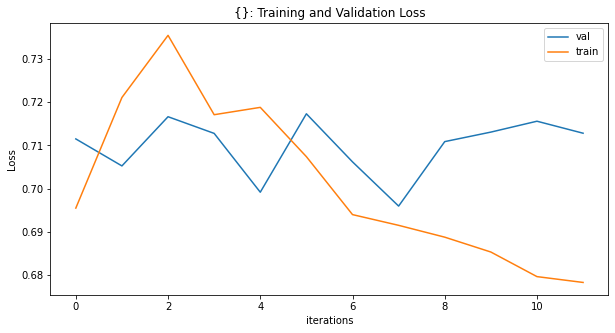

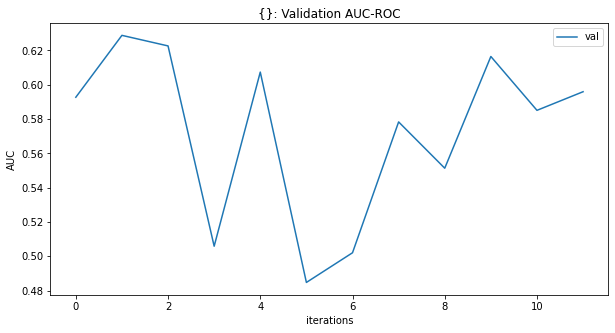

Predict: T1w (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T1w
3,5,1,T1w
8,12,1,T1w
10,17,0,T1w
14,21,0,T1w


465


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T1w
3,5,1,T1w
8,12,1,T1w
10,17,0,T1w
14,21,0,T1w


117
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6974, time: 242.00 s
[Epoch Valid: 1] loss: 0.7141, auc: 0.5665, time: 36.00 s
auc improved from 0.0000 to 0.5665. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_1/T1w-e1-loss0.714-auc0.566.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7082, time: 244.00 s
[Epoch Valid: 2] loss: 0.7134, auc: 0.4412, time: 32.00 s
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7322, time: 243.00 s
[Epoch Valid: 3] loss: 0.6892, auc: 0.5875, time: 34.00 s
auc improved from 0.5665 to 0.5875. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_1/T1w-e3-loss0.689-auc0.588.pth'
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7252, time: 240.00 s
[Epoch Valid: 4] loss: 0.7137, auc: 0.5896, time: 35.00 s
auc improved from 0.5875 to 0.5896. Saved model to 'experiments/seresnext50_stacking

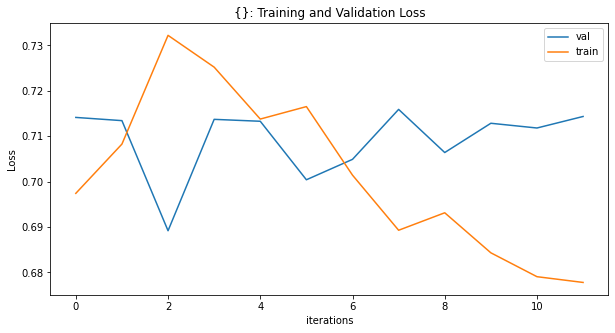

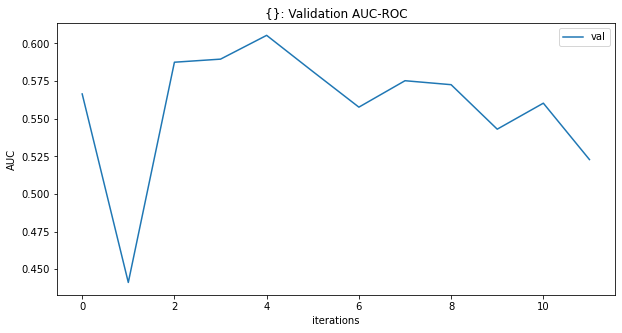

Predict: T1w (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T1w
1,2,1,T1w
9,14,1,T1w
13,20,1,T1w
23,33,1,T1w


466


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T1w
1,2,1,T1w
9,14,1,T1w
13,20,1,T1w
23,33,1,T1w


116
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6893, time: 243.00 s
[Epoch Valid: 1] loss: 0.7164, auc: 0.5911, time: 32.00 s
auc improved from 0.0000 to 0.5911. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_2/T1w-e1-loss0.716-auc0.591.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7205, time: 242.00 s
[Epoch Valid: 2] loss: 0.7163, auc: 0.4215, time: 32.00 s
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7271, time: 244.00 s
[Epoch Valid: 3] loss: 0.7267, auc: 0.5306, time: 33.00 s
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7306, time: 243.00 s
[Epoch Valid: 4] loss: 0.7356, auc: 0.4978, time: 35.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7244, time: 244.00 s
[Epoch Valid: 5] loss: 0.7176, auc: 0.4665, time: 32.00 s
EPOCH: 6
Learning Rate: 7.500001000000001e-05
[Epoch Train: 6] loss: 0.7018, time: 243.00 s
[Epoc

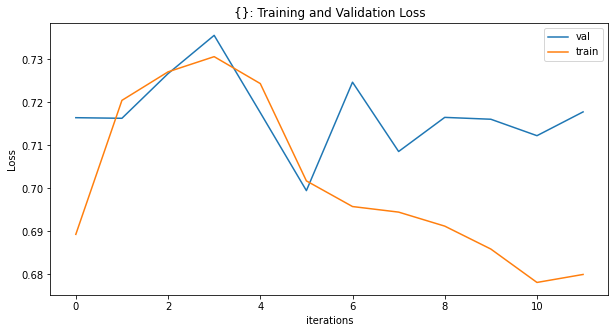

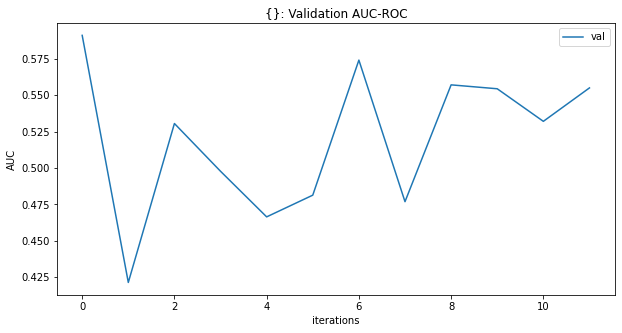

Predict: T1w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T1w
11,18,0,T1w
12,19,0,T1w
16,24,0,T1w
20,30,0,T1w


466


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T1w
11,18,0,T1w
12,19,0,T1w
16,24,0,T1w
20,30,0,T1w


116
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6967, time: 244.00 s
[Epoch Valid: 1] loss: 0.7129, auc: 0.5651, time: 36.00 s
auc improved from 0.0000 to 0.5651. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_3/T1w-e1-loss0.713-auc0.565.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7194, time: 241.00 s
[Epoch Valid: 2] loss: 0.7126, auc: 0.6283, time: 34.00 s
auc improved from 0.5651 to 0.6283. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_3/T1w-e2-loss0.713-auc0.628.pth'
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7425, time: 243.00 s
[Epoch Valid: 3] loss: 0.7015, auc: 0.5979, time: 28.00 s
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7272, time: 241.00 s
[Epoch Valid: 4] loss: 0.6968, auc: 0.4721, time: 31.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7180, time: 2

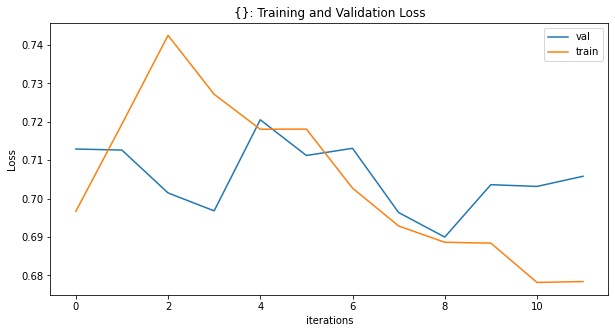

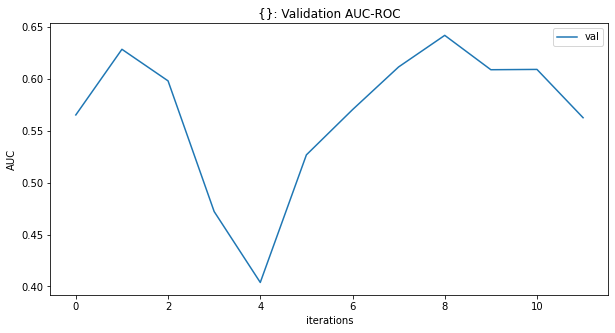

Predict: T1w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,T1w
22,32,0,T1w
27,44,0,T1w
32,52,1,T1w
36,58,1,T1w


466


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,T1w
22,32,0,T1w
27,44,0,T1w
32,52,1,T1w
36,58,1,T1w


116
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6900, time: 243.00 s
[Epoch Valid: 1] loss: 0.7059, auc: 0.5458, time: 36.00 s
auc improved from 0.0000 to 0.5458. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_4/T1w-e1-loss0.706-auc0.546.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7201, time: 242.00 s
[Epoch Valid: 2] loss: 0.6992, auc: 0.5988, time: 29.00 s
auc improved from 0.5458 to 0.5988. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_4/T1w-e2-loss0.699-auc0.599.pth'
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7295, time: 244.00 s
[Epoch Valid: 3] loss: 0.7253, auc: 0.5663, time: 33.00 s
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7102, time: 240.00 s
[Epoch Valid: 4] loss: 0.7182, auc: 0.5718, time: 32.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7229, time: 2

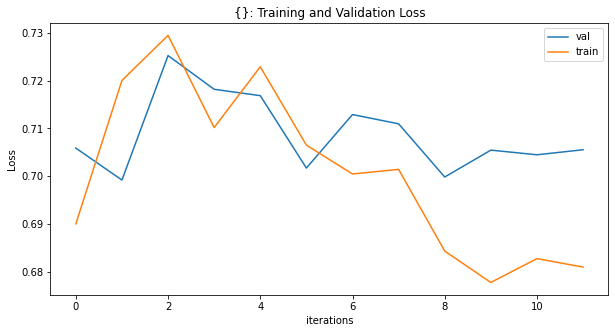

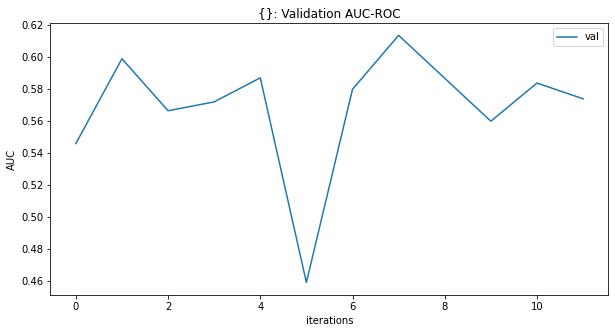

Predict: T1w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,T1wCE
6,9,0,T1wCE
7,11,1,T1wCE
17,25,1,T1wCE
18,26,1,T1wCE


465


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,T1wCE
6,9,0,T1wCE
7,11,1,T1wCE
17,25,1,T1wCE
18,26,1,T1wCE


117
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6989, time: 239.00 s
[Epoch Valid: 1] loss: 0.7129, auc: 0.5962, time: 31.00 s
auc improved from 0.0000 to 0.5962. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_0/T1wCE-e1-loss0.713-auc0.596.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7220, time: 238.00 s
[Epoch Valid: 2] loss: 0.7095, auc: 0.4085, time: 36.00 s
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7554, time: 241.00 s
[Epoch Valid: 3] loss: 0.7113, auc: 0.6150, time: 34.00 s
auc improved from 0.5962 to 0.6150. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_0/T1wCE-e3-loss0.711-auc0.615.pth'
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7060, time: 238.00 s
[Epoch Valid: 4] loss: 0.7125, auc: 0.6270, time: 36.00 s
auc improved from 0.6150 to 0.6270. Saved model to 'experiments/seresnext50_stac

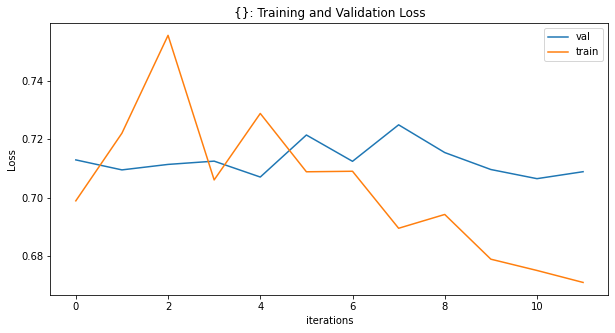

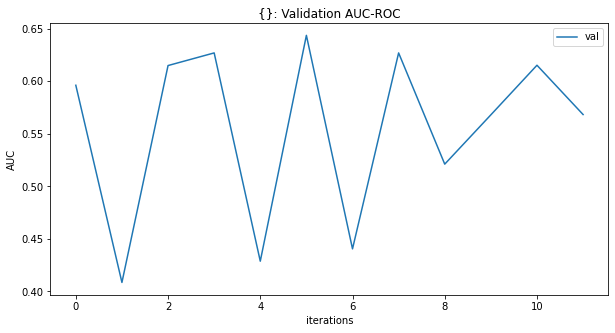

Predict: T1wCE (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T1wCE
3,5,1,T1wCE
8,12,1,T1wCE
10,17,0,T1wCE
14,21,0,T1wCE


465


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T1wCE
3,5,1,T1wCE
8,12,1,T1wCE
10,17,0,T1wCE
14,21,0,T1wCE


117
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6958, time: 240.00 s
[Epoch Valid: 1] loss: 0.7158, auc: 0.5465, time: 34.00 s
auc improved from 0.0000 to 0.5465. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_1/T1wCE-e1-loss0.716-auc0.547.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7079, time: 242.00 s
[Epoch Valid: 2] loss: 0.7054, auc: 0.4959, time: 35.00 s
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7403, time: 241.00 s
[Epoch Valid: 3] loss: 0.7071, auc: 0.5501, time: 37.00 s
auc improved from 0.5465 to 0.5501. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_1/T1wCE-e3-loss0.707-auc0.550.pth'
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7144, time: 242.00 s
[Epoch Valid: 4] loss: 0.7208, auc: 0.5287, time: 27.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7185, tim

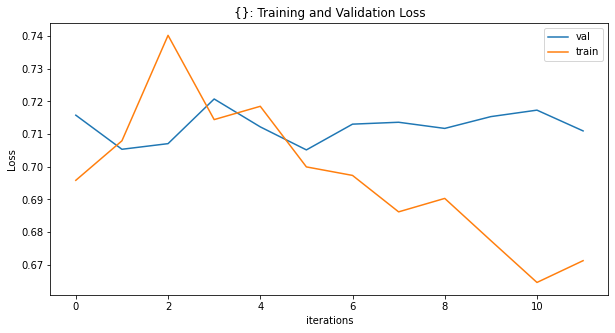

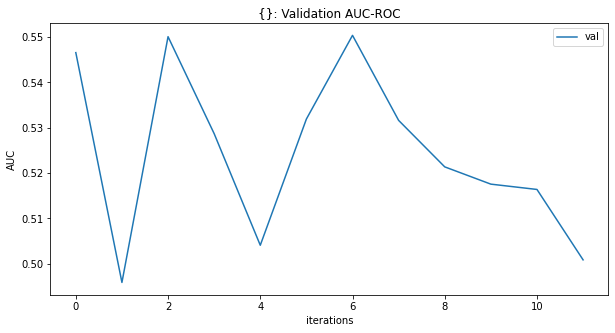

Predict: T1wCE (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T1wCE
1,2,1,T1wCE
9,14,1,T1wCE
13,20,1,T1wCE
23,33,1,T1wCE


466


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T1wCE
1,2,1,T1wCE
9,14,1,T1wCE
13,20,1,T1wCE
23,33,1,T1wCE


116
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6936, time: 243.00 s
[Epoch Valid: 1] loss: 0.7072, auc: 0.5957, time: 34.00 s
auc improved from 0.0000 to 0.5957. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_2/T1wCE-e1-loss0.707-auc0.596.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7111, time: 242.00 s
[Epoch Valid: 2] loss: 0.7017, auc: 0.5273, time: 33.00 s
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7277, time: 242.00 s
[Epoch Valid: 3] loss: 0.7026, auc: 0.6057, time: 31.00 s
auc improved from 0.5957 to 0.6057. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_2/T1wCE-e3-loss0.703-auc0.606.pth'
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7346, time: 242.00 s
[Epoch Valid: 4] loss: 0.7135, auc: 0.3669, time: 32.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7167, tim

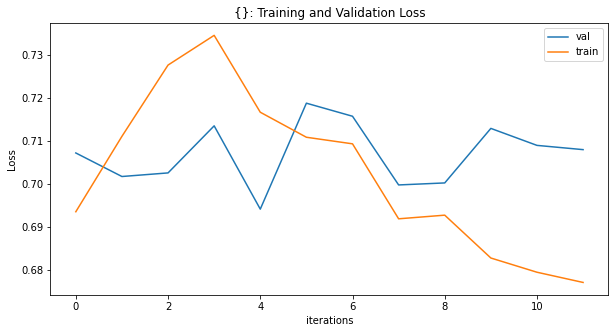

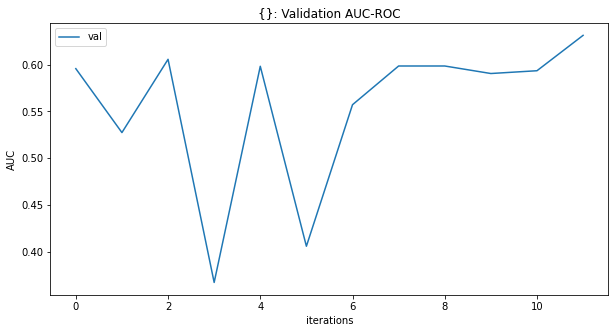

Predict: T1wCE (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T1wCE
11,18,0,T1wCE
12,19,0,T1wCE
16,24,0,T1wCE
20,30,0,T1wCE


466


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T1wCE
11,18,0,T1wCE
12,19,0,T1wCE
16,24,0,T1wCE
20,30,0,T1wCE


116
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6955, time: 241.00 s
[Epoch Valid: 1] loss: 0.7054, auc: 0.5836, time: 35.00 s
auc improved from 0.0000 to 0.5836. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_3/T1wCE-e1-loss0.705-auc0.584.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7261, time: 243.00 s
[Epoch Valid: 2] loss: 0.7081, auc: 0.6206, time: 31.00 s
auc improved from 0.5836 to 0.6206. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_3/T1wCE-e2-loss0.708-auc0.621.pth'
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7196, time: 242.00 s
[Epoch Valid: 3] loss: 0.7243, auc: 0.4247, time: 31.00 s
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7336, time: 244.00 s
[Epoch Valid: 4] loss: 0.6952, auc: 0.5890, time: 33.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7200, tim

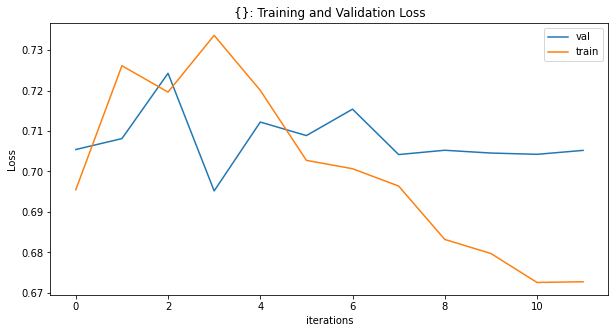

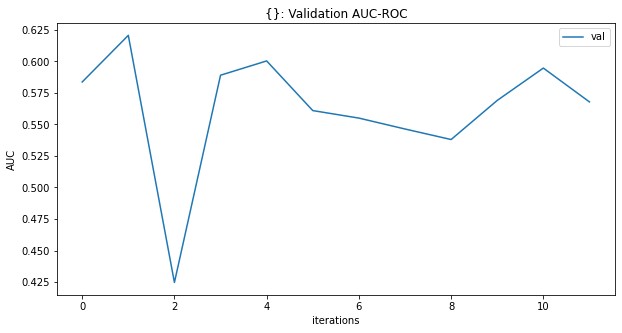

Predict: T1wCE (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,T1wCE
22,32,0,T1wCE
27,44,0,T1wCE
32,52,1,T1wCE
36,58,1,T1wCE


466


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,T1wCE
22,32,0,T1wCE
27,44,0,T1wCE
32,52,1,T1wCE
36,58,1,T1wCE


116
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.7020, time: 242.00 s
[Epoch Valid: 1] loss: 0.7111, auc: 0.5827, time: 33.00 s
auc improved from 0.0000 to 0.5827. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_4/T1wCE-e1-loss0.711-auc0.583.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7134, time: 243.00 s
[Epoch Valid: 2] loss: 0.7029, auc: 0.4316, time: 34.00 s
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7306, time: 243.00 s
[Epoch Valid: 3] loss: 0.7015, auc: 0.4334, time: 38.00 s
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7217, time: 243.00 s
[Epoch Valid: 4] loss: 0.7062, auc: 0.5514, time: 28.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7266, time: 241.00 s
[Epoch Valid: 5] loss: 0.7369, auc: 0.5705, time: 31.00 s
EPOCH: 6
Learning Rate: 7.500001000000001e-05
[Epoch Train: 6] loss: 0.7120, time: 254.00 s
[Ep

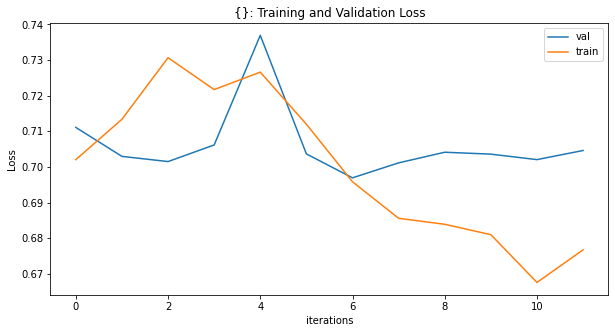

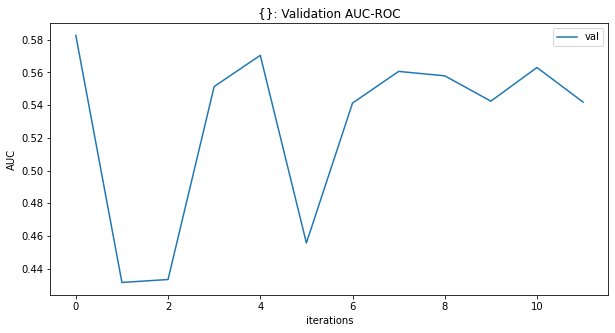

Predict: T1wCE (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,T2w
6,9,0,T2w
7,11,1,T2w
17,25,1,T2w
18,26,1,T2w


465


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,T2w
6,9,0,T2w
7,11,1,T2w
17,25,1,T2w
18,26,1,T2w


117
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6977, time: 261.00 s
[Epoch Valid: 1] loss: 0.7146, auc: 0.5211, time: 35.00 s
auc improved from 0.0000 to 0.5211. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_0/T2w-e1-loss0.715-auc0.521.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7209, time: 258.00 s
[Epoch Valid: 2] loss: 0.7145, auc: 0.5780, time: 37.00 s
auc improved from 0.5211 to 0.5780. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_0/T2w-e2-loss0.715-auc0.578.pth'
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7440, time: 244.00 s
[Epoch Valid: 3] loss: 0.7192, auc: 0.5402, time: 30.00 s
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7114, time: 247.00 s
[Epoch Valid: 4] loss: 0.7144, auc: 0.5188, time: 38.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7062, time: 2

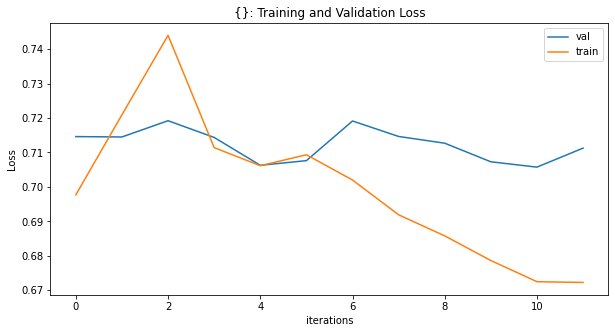

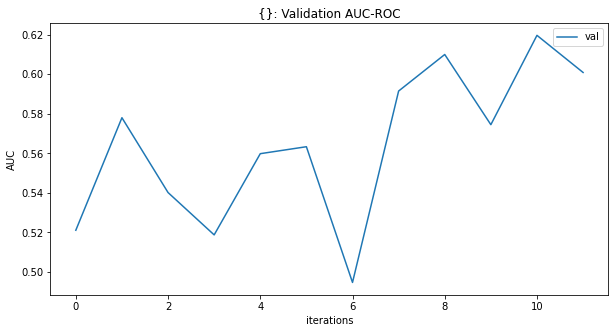

Predict: T2w (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T2w
3,5,1,T2w
8,12,1,T2w
10,17,0,T2w
14,21,0,T2w


465


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T2w
3,5,1,T2w
8,12,1,T2w
10,17,0,T2w
14,21,0,T2w


117
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6952, time: 242.00 s
[Epoch Valid: 1] loss: 0.7147, auc: 0.5237, time: 29.00 s
auc improved from 0.0000 to 0.5237. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_1/T2w-e1-loss0.715-auc0.524.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7224, time: 242.00 s
[Epoch Valid: 2] loss: 0.7200, auc: 0.4731, time: 34.00 s
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7369, time: 241.00 s
[Epoch Valid: 3] loss: 0.7254, auc: 0.6019, time: 30.00 s
auc improved from 0.5237 to 0.6019. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_1/T2w-e3-loss0.725-auc0.602.pth'
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7190, time: 244.00 s
[Epoch Valid: 4] loss: 0.7215, auc: 0.5117, time: 35.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7046, time: 2

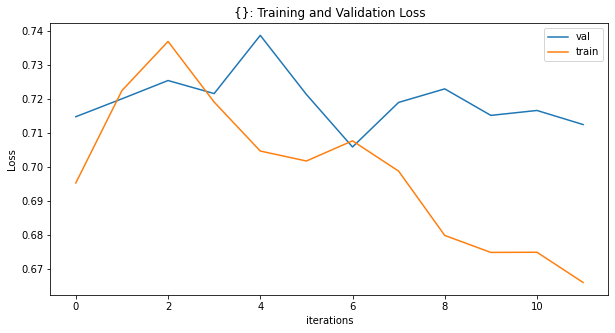

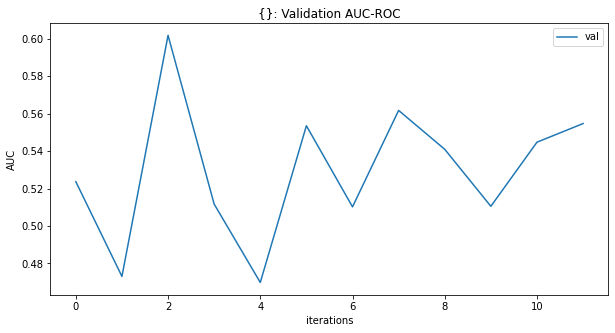

Predict: T2w (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T2w
1,2,1,T2w
9,14,1,T2w
13,20,1,T2w
23,33,1,T2w


466


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T2w
1,2,1,T2w
9,14,1,T2w
13,20,1,T2w
23,33,1,T2w


116
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6965, time: 242.00 s
[Epoch Valid: 1] loss: 0.7093, auc: 0.4930, time: 33.00 s
auc improved from 0.0000 to 0.4930. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_2/T2w-e1-loss0.709-auc0.493.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7286, time: 240.00 s
[Epoch Valid: 2] loss: 0.7055, auc: 0.5860, time: 32.00 s
auc improved from 0.4930 to 0.5860. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_2/T2w-e2-loss0.705-auc0.586.pth'
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7338, time: 240.00 s
[Epoch Valid: 3] loss: 0.7109, auc: 0.4697, time: 33.00 s
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7296, time: 241.00 s
[Epoch Valid: 4] loss: 0.7349, auc: 0.5508, time: 36.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7102, time: 2

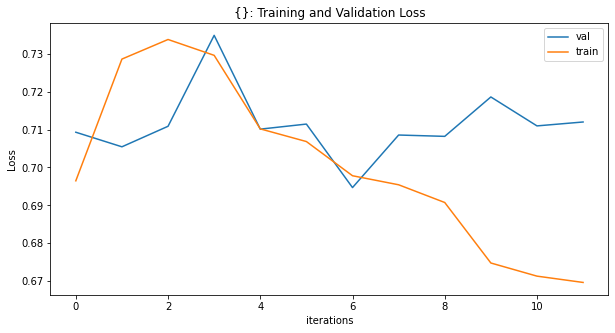

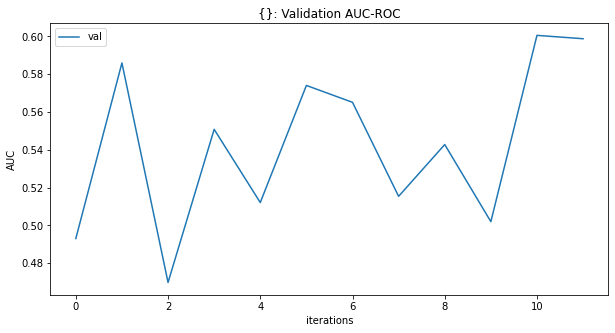

Predict: T2w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T2w
11,18,0,T2w
12,19,0,T2w
16,24,0,T2w
20,30,0,T2w


466


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T2w
11,18,0,T2w
12,19,0,T2w
16,24,0,T2w
20,30,0,T2w


116
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6952, time: 241.00 s
[Epoch Valid: 1] loss: 0.7131, auc: 0.5294, time: 32.00 s
auc improved from 0.0000 to 0.5294. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_3/T2w-e1-loss0.713-auc0.529.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7119, time: 244.00 s
[Epoch Valid: 2] loss: 0.6949, auc: 0.5121, time: 32.00 s
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7325, time: 242.00 s
[Epoch Valid: 3] loss: 0.7021, auc: 0.6075, time: 34.00 s
auc improved from 0.5294 to 0.6075. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_3/T2w-e3-loss0.702-auc0.607.pth'
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7164, time: 239.00 s
[Epoch Valid: 4] loss: 0.7035, auc: 0.5121, time: 32.00 s
EPOCH: 5
Learning Rate: 8.830222683506004e-05
[Epoch Train: 5] loss: 0.7179, time: 2

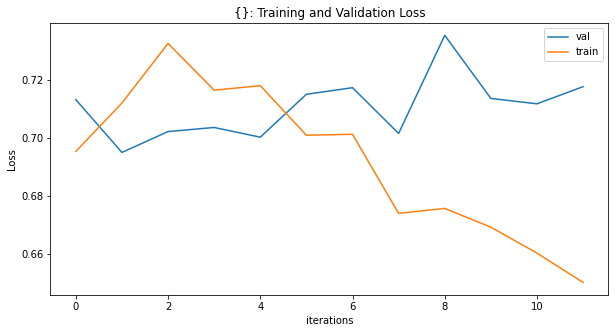

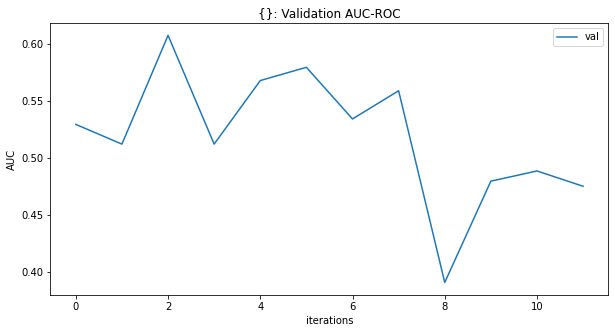

Predict: T2w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,T2w
22,32,0,T2w
27,44,0,T2w
32,52,1,T2w
36,58,1,T2w


466


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,T2w
22,32,0,T2w
27,44,0,T2w
32,52,1,T2w
36,58,1,T2w


116
EPOCH: 1
Learning Rate: 4.000000000000002e-06
[Epoch Train: 1] loss: 0.6925, time: 240.00 s
[Epoch Valid: 1] loss: 0.7131, auc: 0.5210, time: 32.00 s
auc improved from 0.0000 to 0.5210. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_4/T2w-e1-loss0.713-auc0.521.pth'
EPOCH: 2
Learning Rate: 5.2000000000000004e-05
[Epoch Train: 2] loss: 0.7197, time: 243.00 s
[Epoch Valid: 2] loss: 0.7008, auc: 0.5285, time: 31.00 s
auc improved from 0.5210 to 0.5285. Saved model to 'experiments/seresnext50_stacking/experiments/seresnext50_stacking/models/fold_4/T2w-e2-loss0.701-auc0.528.pth'
EPOCH: 3
Learning Rate: 0.0001
[Epoch Train: 3] loss: 0.7263, time: 244.00 s
[Epoch Valid: 3] loss: 0.7437, auc: 0.5183, time: 31.00 s
EPOCH: 4
Learning Rate: 9.698463224544302e-05
[Epoch Train: 4] loss: 0.7314, time: 243.00 s
[Epoch Valid: 4] loss: 0.7023, auc: 0.5586, time: 33.00 s
auc improved from 0.5285 to 0.5586. Saved model to 'experiments/seresnext50_stacking

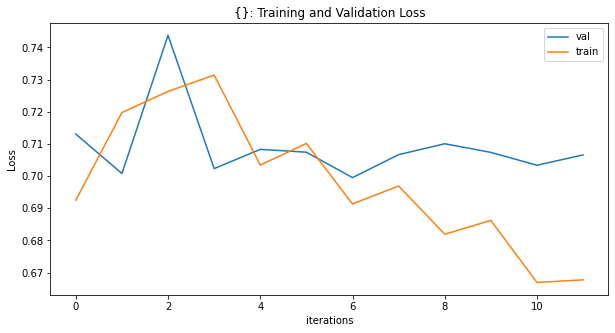

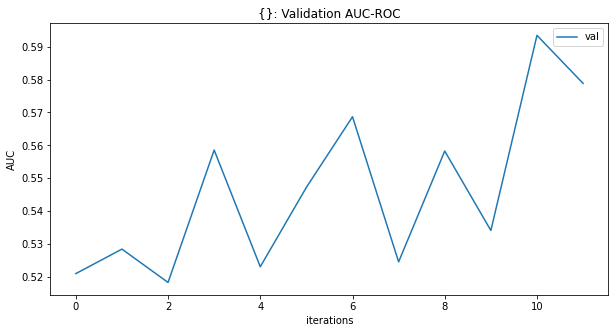

Predict: T2w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
CPU times: user 1d 14h 55min 34s, sys: 4h 39min 21s, total: 1d 19h 34min 55s
Wall time: 18h 47min 54s


In [22]:
%%time

oof_train = []
oof_test = []
modelfiles = []

for mri_type in mri_types:
    trn, tst, modelfile = train_mri_type(df, df_test, mri_type, rkf)
    oof_train.append(trn)
    oof_test.append(tst)
    modelfiles.append(modelfile)

In [23]:
np.save(f"{experiment_folder}/oof_train.npy", oof_train)
np.save(f"{experiment_folder}/oof_test.npy", oof_test)

In [24]:
# oof_train = np.load(f"{experiment_folder}/oof_train.npy")
# oof_test = np.load(f"{experiment_folder}/oof_test.npy")

In [25]:
x_train = np.swapaxes(np.array(oof_train), 0, 1)
x_test = np.swapaxes(np.array(oof_test), 0, 1)

In [26]:
len(df), len(x_train), len(x_test)

(582, 582, 87)

In [27]:
df_test = pd.read_csv(f"{data_directory}/sample_submission.csv")

In [28]:
for i, mri_type in enumerate(mri_types):
    df[f"level0_{mri_type}_preds"] = x_train[:, i]
    df_test[f"level0_{mri_type}_preds"] = x_test[:, i]

In [29]:
y = df["MGMT_value"].values
X = df.drop(["MGMT_value"], axis=1)

In [30]:
if "BraTS21ID" in X.columns:
    X = X.drop(["BraTS21ID"], axis=1)

In [31]:
X.head()

,level0_FLAIR_preds,level0_T1w_preds,level0_T1wCE_preds,level0_T2w_preds
0,0.588553,0.438493,0.606293,0.594135
1,0.573948,0.437726,0.568869,0.614259
2,0.593833,0.532625,0.601111,0.570117
3,0.685178,0.542950,0.605553,0.591476
4,0.556240,0.462511,0.604261,0.586475


In [32]:
params = {
    'learning_rate': [0.005, 0.002, 0.0001],
    'n_estimators': [1000, 2000, 5000],
    'min_child_weight': [1, 10, 20],
    'gamma': [1, 2, 5],
    'subsample': [0.9, 1.0], # 0.6, 0.8, 
    'colsample_bytree': [0.9, 1.0],
    'max_depth': [2, 3, 4, 5]
}

In [33]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [34]:
gbc = xgb.XGBClassifier(
    # objective='binary:logistic',
    # use_label_encoder=False
)

In [35]:
from sklearn.metrics import make_scorer

In [36]:
roc_auc_sklearn = make_scorer(roc_auc_score)

In [37]:
folds = 5
param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=52)

random_search = RandomizedSearchCV(
    gbc,
    param_distributions=params,
    n_iter=param_comb,
    scoring=roc_auc_sklearn,
    n_jobs=8,
    cv=skf.split(X, y),
    random_state=21,
)

random_search.fit(X, y)

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

[23:49:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[23:49:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

[23:49:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

[23:49:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:52:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

[23:49:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

[23:49:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

[00:10:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/christian/miniconda/envs/pytorch/lib/p

[00:06:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:06:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:08:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:08:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f26d6eda7b0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=

In [38]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv(f'{experiment_folder}/xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([  6.06613173,  13.19752841,  33.75455832,  57.44794936,
        64.39495339,  31.43715644,  41.37315092,  62.72978935,
        66.81023612,  73.90001907,   6.15597949,   4.30813923,
        61.86911035,  18.61393876,  53.28081818,  39.22809148,
         4.27816558,   8.14291425,  62.96832738,  31.35618958,
        62.24103007,  12.02694364,  64.73735709,  12.94066858,
        20.38563685, 152.76234097,  26.48806376,   4.24052215,
        74.8869966 ,  30.89939842,  21.40964279,  77.137183  ,
        18.33934197,   8.11253004,  38.41169968,   8.67460904,
        31.54032035,  10.2278944 ,  20.20014553,   5.93494473,
        11.50547366,  14.49559035,  29.61347256,  19.46062169,
         7.89776011,  36.84071188,  38.53262811, 143.88449922,
       107.87330461,   3.86111145,   4.06771564,  88.1250176 ,
        12.89068499,  11.81538095,  12.22884483,  20.65630097,
        19.09679384,  43.2690639 ,  62.70166793,   4.11763401,
        30.66803026,  

In [39]:
results[results["rank_test_score"] < 8].sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,6.155979,0.689223,0.043386,0.007221,1.0,1000,20,7,0.002,5,1.0,"{'subsample': 1.0, 'n_estimators': 1000, 'min_...",0.599413,0.571868,0.595976,0.576900,0.574069,0.583645,0.011633,1
92,5.808950,0.489239,0.066953,0.016436,1.0,1000,20,6,0.002,5,1.0,"{'subsample': 1.0, 'n_estimators': 1000, 'min_...",0.599413,0.571868,0.595976,0.576900,0.574069,0.583645,0.011633,1
6,41.373151,2.278423,0.054617,0.009226,1.0,10000,40,5,0.01,5,1.0,"{'subsample': 1.0, 'n_estimators': 10000, 'min...",0.599413,0.571868,0.595976,0.567809,0.574069,0.581827,0.013156,3
91,7.805201,0.735377,0.063609,0.019254,1.0,2000,40,7,0.005,5,1.0,"{'subsample': 1.0, 'n_estimators': 2000, 'min_...",0.599413,0.571868,0.595976,0.567809,0.574069,0.581827,0.013156,3
89,19.003287,0.864567,0.063314,0.017818,1.0,5000,40,7,0.005,5,1.0,"{'subsample': 1.0, 'n_estimators': 5000, 'min_...",0.599413,0.571868,0.595976,0.567809,0.574069,0.581827,0.013156,3
85,41.139206,1.047194,0.059765,0.026719,1.0,10000,40,5,0.005,5,1.0,"{'subsample': 1.0, 'n_estimators': 10000, 'min...",0.599413,0.571868,0.595976,0.567809,0.574069,0.581827,0.013156,3
83,4.028264,0.385553,0.067301,0.006033,1.0,1000,40,4,0.01,5,1.0,"{'subsample': 1.0, 'n_estimators': 1000, 'min_...",0.599413,0.571868,0.595976,0.567809,0.574069,0.581827,0.013156,3
82,19.289620,1.976787,0.075089,0.012571,1.0,5000,40,4,0.005,5,1.0,"{'subsample': 1.0, 'n_estimators': 5000, 'min_...",0.599413,0.571868,0.595976,0.567809,0.574069,0.581827,0.013156,3
76,40.291343,1.210108,0.082210,0.024571,1.0,10000,40,7,0.01,5,1.0,"{'subsample': 1.0, 'n_estimators': 10000, 'min...",0.599413,0.571868,0.595976,0.567809,0.574069,0.581827,0.013156,3
72,4.335545,0.441713,0.085276,0.026926,1.0,1000,40,6,0.002,5,1.0,"{'subsample': 1.0, 'n_estimators': 1000, 'min_...",0.599413,0.571868,0.595976,0.567809,0.574069,0.581827,0.013156,3


In [48]:
x_test = df_test.copy()

if "BraTS21ID" in x_test.columns:
    x_test = x_test.drop(["BraTS21ID"], axis=1)
if "MGMT_value" in x_test.columns:
    x_test = x_test.drop(["MGMT_value"], axis=1)

In [50]:
test_preds = random_search.predict_proba(x_test)

In [51]:
test_preds = test_preds[:,1]

In [52]:
test_preds

array([0.56611025, 0.5712919 , 0.56994796, 0.55846405, 0.557111  ,
       0.557111  , 0.5788835 , 0.5788835 , 0.56994796, 0.557111  ,
       0.46718976, 0.5048538 , 0.4785311 , 0.4785311 , 0.4785311 ,
       0.46718976, 0.46718976, 0.5048538 , 0.46718976, 0.46718976,
       0.5048538 , 0.46718976, 0.4785311 , 0.46718976, 0.5048538 ,
       0.46718976, 0.4785311 , 0.5048538 , 0.5048538 , 0.46718976,
       0.46718976, 0.4785311 , 0.5048538 , 0.46718976, 0.5048538 ,
       0.4785311 , 0.5048538 , 0.46718976, 0.46718976, 0.5048538 ,
       0.46718976, 0.46718976, 0.46718976, 0.46718976, 0.46718976,
       0.55327415, 0.4785311 , 0.4785311 , 0.4785311 , 0.56994796,
       0.55846405, 0.55846405, 0.557111  , 0.56611025, 0.56611025,
       0.56611025, 0.56611025, 0.557111  , 0.557111  , 0.56611025,
       0.5768829 , 0.55327415, 0.56994796, 0.5712919 , 0.5712919 ,
       0.5788835 , 0.56611025, 0.56611025, 0.5788835 , 0.56611025,
       0.56611025, 0.557111  , 0.5788835 , 0.56611025, 0.55327

In [53]:
np.unique(test_preds)

array([0.46718976, 0.4785311 , 0.48006764, 0.5048538 , 0.55327415,
       0.557111  , 0.55846405, 0.56611025, 0.56994796, 0.5712919 ,
       0.5768829 , 0.5788835 ], dtype=float32)

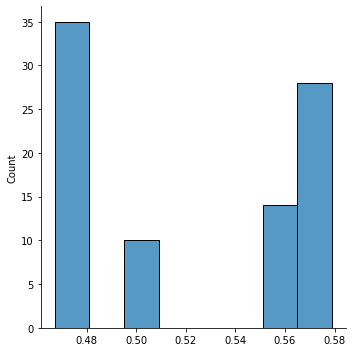

In [54]:
# auc = roc_auc_score(y_valid, val_preds)
# print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(test_preds)

**Submission**

In [55]:
submission = pd.read_csv(f"{data_directory}/sample_submission.csv")
submission["MGMT_value"] = test_preds
submission.to_csv(f"{experiment_folder}/submission_stacking.csv")

In [56]:
tmp_pred = np.array(oof_test).mean(0)

In [57]:
tmp_pred

array([0.58114939, 0.546439  , 0.59362436, 0.56955975, 0.57469336,
       0.58705603, 0.55009003, 0.57363642, 0.62369713, 0.62233959,
       0.44595325, 0.4231837 , 0.47117036, 0.47490703, 0.49427397,
       0.4523234 , 0.45907397, 0.43554362, 0.42741545, 0.44733601,
       0.4292151 , 0.43740678, 0.45456206, 0.4358973 , 0.42748937,
       0.44703147, 0.4578778 , 0.42915003, 0.4465359 , 0.4392181 ,
       0.45351909, 0.45685324, 0.42826684, 0.44454064, 0.4523782 ,
       0.46674603, 0.43625525, 0.44237   , 0.44363083, 0.43409746,
       0.44669151, 0.45553587, 0.44265193, 0.43405153, 0.4422713 ,
       0.57141172, 0.49144118, 0.51786323, 0.48648591, 0.58977579,
       0.56662619, 0.56968773, 0.6218309 , 0.60672426, 0.61762042,
       0.59056014, 0.6044895 , 0.63120674, 0.58131133, 0.62163469,
       0.46981497, 0.55423113, 0.57179998, 0.51646951, 0.59686977,
       0.58133225, 0.58771845, 0.59665325, 0.56126169, 0.5886024 ,
       0.57415989, 0.62869018, 0.58652373, 0.61832226, 0.56963

In [58]:
submission = pd.read_csv(f"{data_directory}/sample_submission.csv")
submission["MGMT_value"] = tmp_pred
submission.to_csv(f"{experiment_folder}/submission_mean.csv")